# Linear Models

Principle : Linear models make a prediction using a linear function of the input features. Each feature is assigned a weight learned by the algorithm.
There are many different linear models for classification. The difference between these models lies in how the model parameters w and b are learned from the training data, and how model complexity can be controlled. The two most common algorithms are *logistic regression* (despites its name) and *linear support vector machines*.
For both of them, the regularization parameter C can be adjusted to get better results. The higher the value, the most the algorithm is gonna give importance to every points for the dataset trying to fit as most as possible to the training set. Using low values means the algorithm is gonna try to adjust to the "majority" of the points.

### Set up

First import all necessary packages in order not to worry about them when testing new parameters/algorithms:

In [9]:
%load_ext autoreload
%autoreload
from LinearModels import display_plot_logreg, display_plot_svc
from utils import feature_selection

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Logistic Regression

### First test

Let's try the logistic regression first with C set to the default value 1, then C=100 and eventually C=0.01.

In [9]:
gt = pd.read_csv('../dumps/2020.01.13-14.25.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

logreg = LogisticRegression(max_iter=100000).fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg.score(data_test, target_test)))

Training set score: 0.839
Test set score: 0.774


In [10]:
logreg100 = LogisticRegression(C=100,max_iter=100000).fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg100.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg100.score(data_test, target_test)))

Training set score: 0.839
Test set score: 0.779


In [11]:
logreg001 = LogisticRegression(C=0.01,max_iter=100000).fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg001.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg001.score(data_test, target_test)))

Training set score: 0.838
Test set score: 0.779


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Intersting to notice that here to values are always quite similar. We should maybe try with more iterations as stated in the erros messages.
We can also add L1 regularization to limit the number of features and see how it goes.

### Further tests

#### Regularization parameter

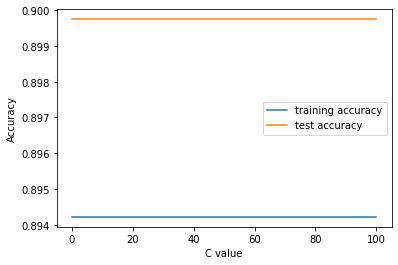

In [24]:
display_plot_logreg('../dumps/2020.02.10-12.14.csv',0.20,0.01,100)

### Best match

In [12]:
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

In [13]:
parameters = {'C': [0.01,0.1, 1, 10, 100], 'max_iter':[100,1000,10000]}
clf = GridSearchCV(LogisticRegression(), parameters, n_jobs=-1)
clf.fit(data_train, target_train)
print(clf.score(data_train, target_train))
print(clf.best_params_)
print(clf.score(data_test, target_test))
print(clf.best_params_)

0.8942172073342737
{'C': 0.01, 'max_iter': 100}
0.899749373433584
{'C': 0.01, 'max_iter': 100}


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [14]:
parameters = {'C': [0.01,0.1, 1, 10, 100], 'max_iter':[100,1000,10000]}
clf = RandomizedSearchCV(LogisticRegression(), parameters, n_jobs=-1)
clf.fit(data_train, target_train)
print(clf.score(data_train, target_train))
print(clf.best_params_)
print(clf.score(data_test, target_test))
print(clf.best_params_)

0.8942172073342737
{'max_iter': 100, 'C': 1}
0.899749373433584
{'max_iter': 100, 'C': 1}


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Features relevance

Here below we will follow an iterative process in order to select the most relevant features of our model. The way it works is as follow : first we start a small training set, measure the accuracy and select the most relevant features using *SelectFromModel*. Then we apply the same reasoning on a slightly larger training set. Between two iterations, the set of features that is kept is the intersection between the current best features and the previous ones.

In [91]:
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
cols = [col for col in gt.columns if col not in ['label']]
raw_data = gt[cols]
raw_target = gt['label']

First step, we start with a training set of 20% of the whole dataset.

In [92]:
#Computing initial accuracies without tuning
data_train, data_test, target_train, target_test = train_test_split(raw_data, raw_target, test_size = 0.85, random_state = 0)
print(data_train.shape)
logreg = LogisticRegression(C=0.01, max_iter=100)
logreg.fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg.score(data_test, target_test)))

#Select best features
model = SelectFromModel(logreg, prefit=True)
train_new = model.transform(data_train)
print(train_new.shape)
mask = model.get_support()
A_set = data_train.columns[mask]

#Creating new dataset with only wanted features and computing new accuracies
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
data = gt[A_set]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.85, random_state = 0)
logreg.fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg.score(data_test, target_test)))

(1196, 119)
Training set score: 0.891
Test set score: 0.855
(1196, 46)
Training set score with 46 features : 0.886
Training set score: 0.886
Test set score: 0.882


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


We now increase the size of the training set.

In [93]:
#Computing initial accuracies without tuning
data_train, data_test, target_train, target_test = train_test_split(raw_data, raw_target, test_size = 0.70, random_state = 0)
print(data_train.shape)
logreg = LogisticRegression(C=0.01, max_iter=100)
logreg.fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg.score(data_test, target_test)))

#Select best features
model = SelectFromModel(logreg, prefit=True)
train_new = model.transform(data_train)
print(train_new.shape)
mask = model.get_support()
B_set = data_train.columns[mask]

#Creating new dataset with only wanted features and computing new accuracies
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
data = gt[B_set]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.70, random_state = 0)
logreg.fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg.score(data_test, target_test)))

#Creating new dataset with A's best features and computing new accuracies
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
data = gt[A_set]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.70, random_state = 0)
logreg.fit(data_train, target_train)
print("Training set score: {:.3f}".format(logreg.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(logreg.score(data_test, target_test)))

#Intersection of two subsets with the best features
C_set = [value for value in B_set if value in A_set]

(2393, 119)
Training set score: 0.896
Test set score: 0.886
(2393, 43)
Training set score with 43 features : 0.901


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Training set score: 0.901
Test set score: 0.893
Training set score: 0.893
Test set score: 0.886


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


We now carry on repeating the same process : increasing the training set, finding the best features and the intersection with the previous set until convergence.

0.15
(1196, 119)
(1196, 46)


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.3
(2393, 119)
(2393, 43)


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


28
0.44999999999999996
(3589, 119)
(3589, 42)


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


20
0.6
(4786, 119)
(4786, 40)


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


19
0.75
(5982, 119)
(5982, 49)


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


16
0.9
(7179, 119)
(7179, 58)


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


15


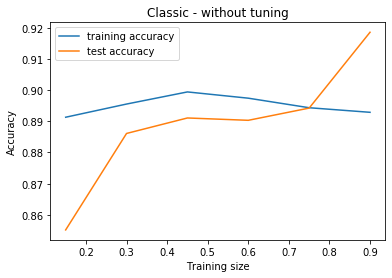

Training max value : 0.8994148787963221
Test max value : 0.918546365914787


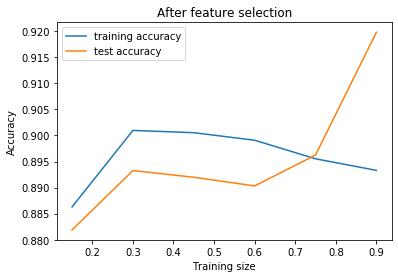

Training max value : 0.9009611366485583
Test max value : 0.9197994987468672


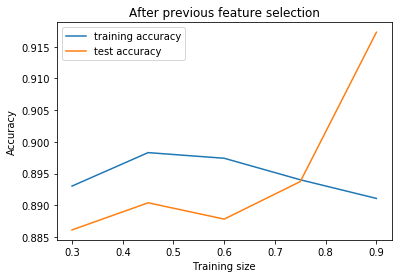

Training max value : 0.898300362217888
Test max value : 0.9172932330827067


In [10]:
feature_selection('../dumps/2020.02.10-12.14.csv', 0.15, "log")

We get the best results when applying feature selection indepedently from the previous results we get on smaller training sets.

## Linear SVC

### First test

Same procedure as done before with logistic regression where a first test is made with C value set to 1, 100 and 0.01.

In [12]:
linsvc = LinearSVC(max_iter=100000).fit(data_train, target_train)
print("Training set score: {:.3f}".format(linsvc.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(linsvc.score(data_test, target_test)))

Training set score: 0.756
Test set score: 0.648


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [13]:
linsvc100 = LinearSVC(C=100).fit(data_train, target_train)
print("Training set score: {:.3f}".format(linsvc100.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(linsvc100.score(data_test, target_test)))

Training set score: 0.590
Test set score: 0.548


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [14]:
linsvc001 = LinearSVC(C=0.01).fit(data_train, target_train)
print("Training set score: {:.3f}".format(linsvc001.score(data_train, target_train))) 
print("Test set score: {:.3f}".format(linsvc001.score(data_test, target_test)))

Training set score: 0.789
Test set score: 0.759


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Further tests

### Regularization parameter

/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


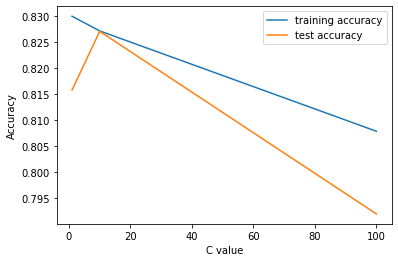

In [15]:
display_plot_svc('../dumps/2020.02.10-12.14.csv',0.20,1,100)

### Best match

In [3]:
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

In [15]:
parameters = {'C': [0.01,0.1, 1, 10, 100], 'max_iter':[100,1000,10000]}
clf = GridSearchCV(LinearSVC(), parameters, n_jobs=-1)
clf.fit(data_train, target_train)
print(clf.score(data_train, target_train))
print(clf.best_params_)
print(clf.score(data_test, target_test))
print(clf.best_params_)

0.7967403228334117
{'C': 0.01, 'max_iter': 100}
0.7894736842105263
{'C': 0.01, 'max_iter': 100}


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [16]:
parameters = {'C': [0.01,0.1, 1, 10, 100], 'max_iter':[100,1000,10000]}
clf = RandomizedSearchCV(LinearSVC(), parameters, n_jobs=-1)
clf.fit(data_train, target_train)
print(clf.score(data_train, target_train))
print(clf.best_params_)
print(clf.score(data_test, target_test))
print(clf.best_params_)

0.7490988873217364
{'max_iter': 1000, 'C': 0.1}
0.7543859649122807
{'max_iter': 1000, 'C': 0.1}


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Features relevance

See LinearRegression in order to understand which processus we follow to generate the values.

0.15
(1196, 119)
(1196, 28)
0.3
(2393, 119)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(2393, 40)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


14
0.44999999999999996
(3589, 119)
(3589, 50)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


8
0.6
(4786, 119)
(4786, 49)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


5
0.75
(5982, 119)
(5982, 35)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


2
0.9
(7179, 119)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(7179, 49)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0


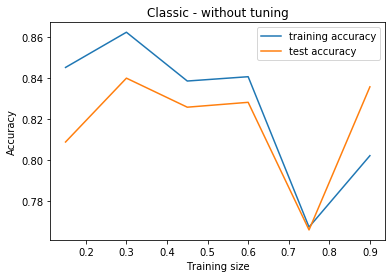

Training max value : 0.8625156707062265
Test max value : 0.8400787965616046


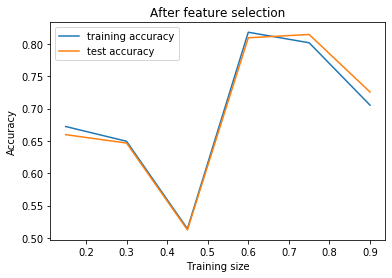

Training max value : 0.8180108650229837
Test max value : 0.8145363408521303


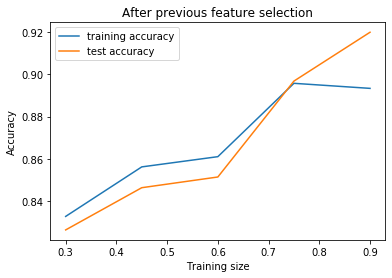

Training max value : 0.8956870611835507
Test max value : 0.9197994987468672


In [8]:
feature_selection('../dumps/2020.02.10-12.14.csv', 0.15, "svc")

The results here are different that the other linear algorithm. We have multiple drops at different intervals and the best value we get is when considering the intersection of all the best features.